Define functional categories and filter calls for those in Control and SCZ individuals

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re
import attila_utils
import funcvar
import functools
import ensembl_rest
import os.path
from bsmcalls import SNPnexus
from bsmcalls import operations
from bsmcalls import resources
from bsmcalls import individuals
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', -1)

## Preparations

Load data: annotated calls

In [2]:
data = SNPnexus.load_data('/home/attila/projects/bsm/results/2020-09-07-annotations/annotated-calls.p')

### GWAS genes

Here we take supplementary table 4 from the [CLOZUK paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5918692/) (clozapine UK), whose `Gene(s) tagged` column we turn into the `gwasgenes` set.

In [3]:
clozukpath = '/home/attila/projects/bsm/resources/CLOZUK/supp-table-4.csv'
gwasgenes = operations.get_geneset(df=pd.read_csv(clozukpath, skiprows=7), col='Gene(s) tagged')
print(len(gwasgenes), 'SCZ GWAS genes')

478 SCZ GWAS genes


### Brain expressed genes

#### RoadMap Epigenomics
`BRN.HIPP.MID` is the hippocampus of an adult whereas `BRN.FET.F` the brain of a female fetus (see [the RoadMap metadata](https://docs.google.com/spreadsheets/d/1yikGx4MsO9Ei36b64yOy9Vb6oPC5IBGlFbYEt-N6gOM/edit?usp=sharing)).

In [4]:
rna_roadmap = resources.read_roadmap_rna(sampledict={'E071': 'BRN.HIPP.MID', 'E082': 'BRN.FET.F'})
rna_roadmap

,BRN.HIPP.MID,BRN.FET.F
ENSG00000000003,35.083,53.039
ENSG00000000005,0.251,0.566
ENSG00000000419,26.467,29.927
ENSG00000000457,5.325,8.497
ENSG00000000460,1.487,3.408
...,...,...
ENSG00000259718,0.112,0.000
ENSG00000259741,38.850,45.583
ENSG00000259752,0.048,0.265
ENSG00000259765,0.000,0.000


The distribution of read counts is extremely skewed to the right, which makes it hard to assess correlation

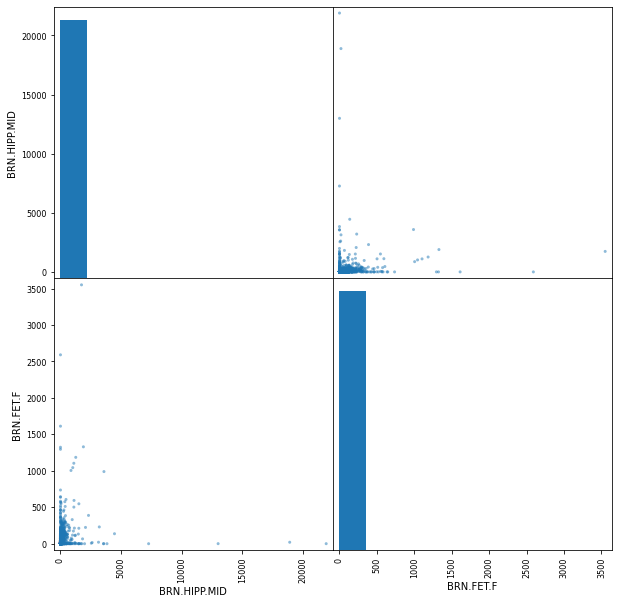

In [5]:
ax = pd.plotting.scatter_matrix(rna_roadmap, figsize=(10, 10))

The log readcount distribution is visually more informative.  There is a clear correlation between `BRN.HIPP.MID` and `BRN.FET.F`.

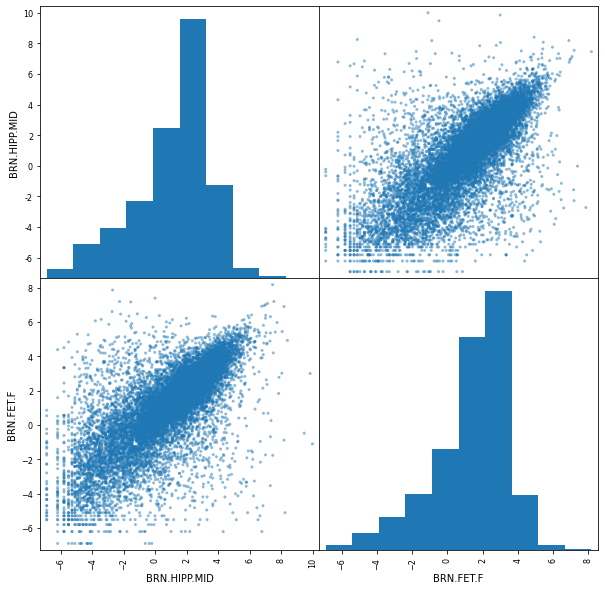

In [6]:
log_rna_roadmap = rna_roadmap.loc[~(rna_roadmap == 0).sum(axis=1).astype('bool')].apply(np.log)
rna = log_rna_roadmap
ax = pd.plotting.scatter_matrix(rna, figsize=(10, 10))

#### Protein Atlas
The [Human Protein Atlas](https://www.proteinatlas.org/humanproteome/brain/human+brain) contains several gene sets based on expression in the brain
1. `brain enriched`
1. `brain elevated`

In [7]:
pa_enriched = resources.read_proteinatlas_rna_brain('enriched')
pa_elevated = resources.read_proteinatlas_rna_brain('elevated')
print(len(pa_enriched), 'genes in the brain enriched set')
print(len(pa_elevated), 'genes in the brain elevated set')
pa_elevated

488 genes in the brain enriched set
2587 genes in the brain elevated set


,Gene,Gene synonym,Gene all names
Ensembl,,,
ENSG00000149452,SLC22A8,{OAT3},"{OAT3, SLC22A8}"
ENSG00000138136,LBX1,"{HPX6, LBX1H}","{LBX1, HPX6, LBX1H}"
ENSG00000131095,GFAP,{FLJ45472},"{FLJ45472, GFAP}"
ENSG00000164438,TLX3,"{RNX, HOX11L2}","{TLX3, RNX, HOX11L2}"
ENSG00000171532,NEUROD2,"{bHLHa1, NDRF}","{bHLHa1, NDRF, NEUROD2}"
...,...,...,...
ENSG00000172000,ZNF556,{FLJ11637},"{FLJ11637, ZNF556}"
ENSG00000173041,ZNF680,{FLJ90430},"{ZNF680, FLJ90430}"
ENSG00000182141,ZNF708,"{KOX8, ZNF15, ZNF15L1}","{KOX8, ZNF15, ZNF708, ZNF15L1}"


The following operations show that 123 genes in the `brain elevated` set of the Human Protein Atlas

In [8]:
print('protein_atlas_elevated AND NOT roadmap:', len(set(pa_elevated.index).difference(set(rna_roadmap.index))))
print('roadmap AND NOT protein_atlas_elevated:', len(set(rna_roadmap.index).difference(set(pa_elevated.index))))

protein_atlas_elevated AND NOT roadmap: 123
roadmap AND NOT protein_atlas_elevated: 17331


On the other hand, the `brain enriched` set (also from the Human Protein Atlas) is a proper subset of the `brain elevated` set.

In [9]:
set(pa_enriched.index).difference(set(pa_elevated.index))

set()

In [10]:
print('protein_atlas_elevated AND NOT log roadmap:', len(set(pa_elevated.index).difference(set(log_rna_roadmap.index))))
print('log roadmap AND NOT protein_atlas_elevated:', len(set(log_rna_roadmap.index).difference(set(pa_elevated.index))))

protein_atlas_elevated AND NOT log roadmap: 296
log roadmap AND NOT protein_atlas_elevated: 15736


#### Discrepancy between Protein Atlas and RoadMap
It is reasonable to expect the `brain enriched` and `brain elevated` gene sets from the Protein Atlas to exhibit an increased expression in the `BRN.HIPP.MID` and `BRN.FET.F` RNA seq data.  However, it isn't so as the bit of analysis below shows.

In [11]:
pa_enriched1 = pa_enriched.drop(set(pa_enriched.index).difference(set(log_rna_roadmap.index)))
log_rna_roadmap['brain enriched'] = False
log_rna_roadmap.loc[pa_enriched1.index, 'brain enriched'] = True
# Now the same for the brain elevated set
pa_elevated1 = pa_elevated.drop(set(pa_elevated.index).difference(set(log_rna_roadmap.index)))
log_rna_roadmap['brain elevated'] = False
log_rna_roadmap.loc[pa_elevated1.index, 'brain elevated'] = True
rna['gene set'] = 'other genes'
rna.loc[rna['brain elevated'], 'gene set'] = 'brain elevated'
rna.loc[rna['brain enriched'], 'gene set'] = 'brain enriched'
categories = ['brain enriched', 'brain elevated', 'other genes']
rna['gene set'] = pd.Categorical(rna['gene set'], categories=categories)
categories.reverse()

['named-figure/brain-elevated-vs-other-genes-log-RPKM.png',
 'named-figure/brain-elevated-vs-other-genes-log-RPKM.pdf']

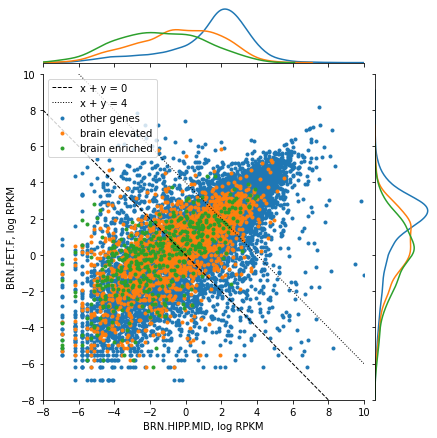

In [12]:
g = sns.JointGrid()
for color, gset in zip(['C0', 'C1', 'C2'], categories):
    g.ax_joint.scatter(x='BRN.HIPP.MID', y='BRN.FET.F', color=color, marker='.', data=rna.loc[rna['gene set'] == gset], label=gset)
    sns.kdeplot(x=rna.loc[rna['gene set'] == gset, 'BRN.HIPP.MID'], ax=g.ax_marg_x)
    sns.kdeplot(y=rna.loc[rna['gene set'] == gset, 'BRN.FET.F'], ax=g.ax_marg_y)
g.ax_marg_x.set_xlim(-8, 10)
g.ax_marg_y.set_ylim(-8, 10)
g.ax_joint.set_xlabel('BRN.HIPP.MID, log RPKM')
g.ax_joint.set_ylabel('BRN.FET.F, log RPKM')
g.ax_joint.plot([8, -8], [-8, 8], linewidth=1, linestyle='dashed', color='k', label='x + y = 0')
g.ax_joint.plot([10, -6], [-6, 10], linewidth=1, linestyle='dotted', color='k', label='x + y = 4')
g.ax_joint.legend()
attila_utils.savefig(g.fig, 'brain-elevated-vs-other-genes-log-RPKM')

In [13]:
brain_elevated_roadmap = {t: set(rna.index[(rna['BRN.HIPP.MID'] + rna['BRN.FET.F']) > t]) for t in [0, 4]}

## Results: calls in functional categories
### Example

In [14]:
# near_gens
queryitems = ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)']
df = operations.query(queryitems, feature='near_gens_Annotation', data=data)
df['Dx'] = data['Dx']
df.groupby('Dx').sum().T

Dx                                           Control  SCZ  ASD
Feature              Query                                    
near_gens_Annotation coding nonsyn                23   43   23
                     coding syn                   16   20   15
                     missense                      0    0    0
                     stop-gain                     1    0    0
                     intronic (splice_site)        0    1    0

### All calls

In [15]:
# near_gens
querydict = {'near_gens_Annotation': ['coding nonsyn', 'coding syn', 'missense', 'stop-gain', 'intronic (splice_site)'],
             'ensembl_Predicted Function': ['coding'],
             'sift_Prediction': ['Deleterious', 'Deleterious - Low Confidence'],
             'polyphen_Prediction': ['Probably Damaging', 'Possibly Damaging'],
             'tfbs_TFBS Name': None,
             'phast_Score': None,
             'gerp_Element RS Score': None,
             'cpg_CpG Island': None,
             'near_gens_Overlapped Gene': {'SCZ GWAS genes': gwasgenes},
             'ensembl_Gene': {'high expr in brain x+y=0': brain_elevated_roadmap[0], 'high expr in brain x+y=4': brain_elevated_roadmap[4], 'brain elevated HPA': set(pa_elevated.index), 'brain enriched HPA': set(pa_enriched.index)},
            }
results = operations.multiquery(querydict, data, do_sum=False, do_sort=False)
summary = operations.summarize_query_results(results, data)
summary#.style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                      23   43   23   
                           coding syn                         16   20   15   
                           missense                            0    0    0   
                           stop-gain                           1    0    0   
                           intronic (splice_site)              0    1    0   
ensembl_Predicted Function coding                             39   64   40   
sift_Prediction            Deleterious                         8    9    6   
                           Deleterious - Low Confidence        1    1    2   
polyphen_Prediction        Probably Damaging                   3    5    2   
                           Possibly Damaging                   2    2    0   
tfbs_TFBS Name             any                                48   78   50   
phast_Score                any                               102  174  141   
gerp_Element RS Score      any                               140  262  208   
cpg_CpG Island             any                                26   47   19   
near_gens_Overlapped Gene  SCZ GWAS genes                     20   66   42   
ensembl_Gene               high expr in brain x+y=0          570  933  701   
                           high expr in brain x+y=4          279  438  314   
                           brain elevated HPA                211  344  280   
                           brain enriched HPA                 42   69   59   

                                                          All  chisq stat  \
Feature                    Query                                            
near_gens_Annotation       coding nonsyn                   89    4.765326   
                           coding syn                      51    1.371564   
                           missense                         0         NaN   
                           stop-gain                        1    2.950000   
                           intronic (splice_site)           1    1.590164   
ensembl_Predicted Function coding                         143    4.219225   
sift_Prediction            Deleterious                     23    1.451859   
                           Deleterious - Low Confidence     4    0.406971   
polyphen_Prediction        Probably Damaging               10    1.139182   
                           Possibly Damaging                4    2.540164   
tfbs_TFBS Name             any                            176    4.620352   
phast_Score                any                            417    1.763406   
gerp_Element RS Score      any                            610    4.990139   
cpg_CpG Island             any                             92   10.092813   
near_gens_Overlapped Gene  SCZ GWAS genes                 128   10.690924   
ensembl_Gene               high expr in brain x+y=0      2204   19.318195   
                           high expr in brain x+y=4      1031   14.276967   
                           brain elevated HPA             835    2.948368   
                           brain enriched HPA             170    0.286225   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.092304  
                           coding syn                    0.503696  
                           missense                           NaN  
                           stop-gain                     0.228779  
                           intronic (splice_site)        0.451544  
ensembl_Predicted Function coding                        0.121285  
sift_Prediction            Deleterious                   0.483875  
                           Deleterious - Low Confidence  0.815882  
polyphen_Prediction        Probably Damaging             0.565757  
                           Possibly Damaging        

### The Chess data set

In [16]:
operations.multiquery(querydict, data.loc[data['Dataset'] == 'Chess'], do_sum=True, do_sort=False).style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp
/home/attila/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1209: RuntimeWarning: All-NaN slice encountered
  smin = np.nanmin(s.to_numpy()) if vmin is None else vmin
/home/attila/anaconda3/lib/python3.7/site-packages/pandas/io/formats/style.py:1210: RuntimeWarning: All-NaN slice encountered
  smax = np.nanmax(s.to_numpy()) if vmax is None else vmax


### Among calls in brain expressed genes

In [17]:
ix = summary.xs('ensembl_Gene', level='Feature', axis=0, drop_level=False).index
results_expr = {x[1]: operations.multiquery(querydict, data.loc[results[x].astype('bool')], do_sum=False, do_sort=False) for x in ix}
summary_expr = {x[1]: operations.multiquery(querydict, data.loc[results[x].astype('bool')], do_sum=True, do_sort=False) for x in ix}
results_expr.keys()

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


dict_keys(['high expr in brain x+y=0', 'high expr in brain x+y=4', 'brain elevated HPA', 'brain enriched HPA'])

In [18]:
summary_expr['high expr in brain x+y=0']#.style.bar(subset='chisq stat')

Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                      14   33   20   
                           coding syn                         11   15   15   
                           missense                            0    0    0   
                           stop-gain                           0    0    0   
                           intronic (splice_site)              0    1    0   
ensembl_Predicted Function coding                             25   49   36   
sift_Prediction            Deleterious                         5    9    6   
                           Deleterious - Low Confidence        0    1    2   
polyphen_Prediction        Probably Damaging                   2    5    2   
                           Possibly Damaging                   1    1    0   
tfbs_TFBS Name             any                                24   46   25   
phast_Score                any                                50   91   60   
gerp_Element RS Score      any                                64  128   83   
cpg_CpG Island             any                                17   40   15   
near_gens_Overlapped Gene  SCZ GWAS genes                     16   47   31   
ensembl_Gene               high expr in brain x+y=0          570  933  701   
                           high expr in brain x+y=4          279  438  314   
                           brain elevated HPA                 81  132  111   
                           brain enriched HPA                  9   23   18   

                                                          All  chisq stat  \
Feature                    Query                                            
near_gens_Annotation       coding nonsyn                   67    3.203887   
                           coding syn                      41    0.083441   
                           missense                         0         NaN   
                           stop-gain                        0         NaN   
                           intronic (splice_site)           1    1.590164   
ensembl_Predicted Function coding                         110    1.637770   
sift_Prediction            Deleterious                     20    0.417138   
                           Deleterious - Low Confidence     3    1.559294   
polyphen_Prediction        Probably Damaging                9    1.182424   
                           Possibly Damaging                2    1.270082   
tfbs_TFBS Name             any                             95    4.878348   
phast_Score                any                            201    4.488034   
gerp_Element RS Score      any                            275    7.590074   
cpg_CpG Island             any                             72   10.076340   
near_gens_Overlapped Gene  SCZ GWAS genes                  94    5.964858   
ensembl_Gene               high expr in brain x+y=0      2204   19.318195   
                           high expr in brain x+y=4      1031   14.276967   
                           brain elevated HPA             324    0.691092   
                           brain enriched HPA              50    1.765040   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.201504  
                           coding syn                    0.959138  
                           missense                           NaN  
                           stop-gain                          NaN  
                           intronic (splice_site)        0.451544  
ensembl_Predicted Function coding                        0.440923  
sift_Prediction            Deleterious                   0.811745  
                           Deleterious - Low Confidence  0.458568  
polyphen_Prediction        Probably Damaging             0.553656  
                           Possibly Damaging        

In [19]:
summary_expr['high expr in brain x+y=4']#.style.bar(subset='chisq stat')

Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                      13   25   10   
                           coding syn                          7    7   12   
                           missense                            0    0    0   
                           stop-gain                           0    0    0   
                           intronic (splice_site)              0    1    0   
ensembl_Predicted Function coding                             20   33   22   
sift_Prediction            Deleterious                         5    7    3   
                           Deleterious - Low Confidence        0    1    2   
polyphen_Prediction        Probably Damaging                   2    4    1   
                           Possibly Damaging                   1    1    0   
tfbs_TFBS Name             any                                15   25   14   
phast_Score                any                                32   49   39   
gerp_Element RS Score      any                                37   71   46   
cpg_CpG Island             any                                13   28   10   
near_gens_Overlapped Gene  SCZ GWAS genes                      6   18   11   
ensembl_Gene               high expr in brain x+y=0          287  453  322   
                           high expr in brain x+y=4          279  438  314   
                           brain elevated HPA                 17   29   18   
                           brain enriched HPA                  1    4    3   

                                                          All  chisq stat  \
Feature                    Query                                            
near_gens_Annotation       coding nonsyn                   48    6.362957   
                           coding syn                      26    1.311100   
                           missense                         0         NaN   
                           stop-gain                        0         NaN   
                           intronic (splice_site)           1    1.701754   
ensembl_Predicted Function coding                          75    2.198129   
sift_Prediction            Deleterious                     15    1.863450   
                           Deleterious - Low Confidence     3    1.502924   
polyphen_Prediction        Probably Damaging                7    1.761404   
                           Possibly Damaging                2    1.275877   
tfbs_TFBS Name             any                             54    3.118340   
phast_Score                any                            120    1.155673   
gerp_Element RS Score      any                            154    5.786404   
cpg_CpG Island             any                             51    8.588252   
near_gens_Overlapped Gene  SCZ GWAS genes                  35    3.310877   
ensembl_Gene               high expr in brain x+y=0      1062   22.438482   
                           high expr in brain x+y=4      1031   20.780207   
                           brain elevated HPA              64    2.565529   
                           brain enriched HPA               8    0.924232   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.041524  
                           coding syn                    0.519156  
                           missense                           NaN  
                           stop-gain                          NaN  
                           intronic (splice_site)        0.427040  
ensembl_Predicted Function coding                        0.333183  
sift_Prediction            Deleterious                   0.393874  
                           Deleterious - Low Confidence  0.471676  
polyphen_Prediction        Probably Damaging             0.414492  
                           Possibly Damaging        

In [20]:
summary_expr['brain elevated HPA']#.style.bar(subset='chisq stat')

Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                       3    5    0   
                           coding syn                          2    4    2   
                           missense                            0    0    0   
                           stop-gain                           1    0    0   
                           intronic (splice_site)              0    0    0   
ensembl_Predicted Function coding                              5    9    3   
sift_Prediction            Deleterious                         0    1    0   
                           Deleterious - Low Confidence        0    0    0   
polyphen_Prediction        Probably Damaging                   0    1    0   
                           Possibly Damaging                   0    0    0   
tfbs_TFBS Name             any                                 6   12    7   
phast_Score                any                                11   33   16   
gerp_Element RS Score      any                                18   54   27   
cpg_CpG Island             any                                 3    9    2   
near_gens_Overlapped Gene  SCZ GWAS genes                      5   21   13   
ensembl_Gene               high expr in brain x+y=0           83  138  117   
                           high expr in brain x+y=4           19   30   19   
                           brain elevated HPA                211  344  280   
                           brain enriched HPA                 42   69   59   

                                                         All  chisq stat  \
Feature                    Query                                           
near_gens_Annotation       coding nonsyn                   8    4.599087   
                           coding syn                      8    0.569698   
                           missense                        0         NaN   
                           stop-gain                       1    2.948718   
                           intronic (splice_site)          0         NaN   
ensembl_Predicted Function coding                         17    2.699510   
sift_Prediction            Deleterious                     1    1.610169   
                           Deleterious - Low Confidence    0         NaN   
polyphen_Prediction        Probably Damaging               1    1.610169   
                           Possibly Damaging               0         NaN   
tfbs_TFBS Name             any                            25    1.110730   
phast_Score                any                            60    7.071157   
gerp_Element RS Score      any                            99   11.054433   
cpg_CpG Island             any                            14    4.425871   
near_gens_Overlapped Gene  SCZ GWAS genes                 39    4.962890   
ensembl_Gene               high expr in brain x+y=0      338    0.921703   
                           high expr in brain x+y=4       68    2.108672   
                           brain elevated HPA            835    3.656154   
                           brain enriched HPA            170    0.384149   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.100305  
                           coding syn                    0.752128  
                           missense                           NaN  
                           stop-gain                     0.228925  
                           intronic (splice_site)             NaN  
ensembl_Predicted Function coding                        0.259304  
sift_Prediction            Deleterious                   0.447050  
                           Deleterious - Low Confidence       NaN  
polyphen_Prediction        Probably Damaging             0.447050  
                           Possibly Damaging                  NaN  
tfbs_

In [21]:
summary_expr['brain enriched HPA']#.style.bar(subset='chisq stat')

Control  SCZ  ASD  \
Feature                    Query                                             
near_gens_Annotation       coding nonsyn                       1    0    0   
                           coding syn                          0    3    0   
                           missense                            0    0    0   
                           stop-gain                           0    0    0   
                           intronic (splice_site)              0    0    0   
ensembl_Predicted Function coding                              1    3    0   
sift_Prediction            Deleterious                         0    0    0   
                           Deleterious - Low Confidence        0    0    0   
polyphen_Prediction        Probably Damaging                   0    0    0   
                           Possibly Damaging                   0    0    0   
tfbs_TFBS Name             any                                 0    4    0   
phast_Score                any                                 2    9    2   
gerp_Element RS Score      any                                 3   12    4   
cpg_CpG Island             any                                 0    2    0   
near_gens_Overlapped Gene  SCZ GWAS genes                      3    4    2   
ensembl_Gene               high expr in brain x+y=0           11   24   19   
                           high expr in brain x+y=4            2    4    3   
                           brain elevated HPA                 43   70   59   
                           brain enriched HPA                 42   69   59   

                                                         All  chisq stat  \
Feature                    Query                                           
near_gens_Annotation       coding nonsyn                   1    3.285714   
                           coding syn                      3    3.923077   
                           missense                        0         NaN   
                           stop-gain                       0         NaN   
                           intronic (splice_site)          0         NaN   
ensembl_Predicted Function coding                          4    2.263736   
sift_Prediction            Deleterious                     0         NaN   
                           Deleterious - Low Confidence    0         NaN   
polyphen_Prediction        Probably Damaging               0         NaN   
                           Possibly Damaging               0         NaN   
tfbs_TFBS Name             any                             4    5.230769   
phast_Score                any                            13    3.620456   
gerp_Element RS Score      any                            19    3.046270   
cpg_CpG Island             any                             2    2.615385   
near_gens_Overlapped Gene  SCZ GWAS genes                  9    0.721612   
ensembl_Gene               high expr in brain x+y=0       54    0.274115   
                           high expr in brain x+y=4        9    0.007326   
                           brain elevated HPA            172    0.528942   
                           brain enriched HPA            170    0.528959   

                                                          chisq p  
Feature                    Query                                   
near_gens_Annotation       coding nonsyn                 0.193427  
                           coding syn                    0.140642  
                           missense                           NaN  
                           stop-gain                          NaN  
                           intronic (splice_site)             NaN  
ensembl_Predicted Function coding                        0.322430  
sift_Prediction            Deleterious                        NaN  
                           Deleterious - Low Confidence       NaN  
polyphen_Prediction        Probably Damaging                  NaN  
                           Possibly Damaging                  NaN  
tfbs_

### Among calls in SCZ GWAS genes
Now first filter for SNVs in SCZ GWAS genes and repeat the calculations

In [22]:
s = results[('near_gens_Overlapped Gene', 'SCZ GWAS genes')]
l = [results[x] & s for x in results.iloc[:, :-2]]
df = pd.concat(l, axis=1)
df = pd.DataFrame(df.to_numpy(), index=df.index, columns=results.columns[:-2])
results_gwas = df
operations.summarize_query_results(df, data)#.style.bar(subset='chisq stat')

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


Control  SCZ  ASD  \
near_gens_Annotation       coding nonsyn                       1    0    0   
                           coding syn                          0    0    0   
                           missense                            0    0    0   
                           stop-gain                           0    0    0   
                           intronic (splice_site)              0    0    0   
ensembl_Predicted Function coding                              1    0    0   
sift_Prediction            Deleterious                         0    0    0   
                           Deleterious - Low Confidence        0    0    0   
polyphen_Prediction        Probably Damaging                   0    0    0   
                           Possibly Damaging                   0    0    0   
tfbs_TFBS Name             any                                 1    2    1   
phast_Score                any                                 1    7    3   
gerp_Element RS Score      any                                 3    9    6   
cpg_CpG Island             any                                 1    1    0   
near_gens_Overlapped Gene  SCZ GWAS genes                     20   66   42   
ensembl_Gene               high expr in brain x+y=0           15   47   31   
                           high expr in brain x+y=4            6   18   11   
                           brain elevated HPA                  5   21   13   

                                                         All  chisq stat  \
near_gens_Annotation       coding nonsyn                   1    2.950000   
                           coding syn                      0         NaN   
                           missense                        0         NaN   
                           stop-gain                       0         NaN   
                           intronic (splice_site)          0         NaN   
ensembl_Predicted Function coding                          1    2.950000   
sift_Prediction            Deleterious                     0         NaN   
                           Deleterious - Low Confidence    0         NaN   
polyphen_Prediction        Probably Damaging               0         NaN   
                           Possibly Damaging               0         NaN   
tfbs_TFBS Name             any                             4    0.270646   
phast_Score                any                            11    3.165036   
gerp_Element RS Score      any                            18    1.174597   
cpg_CpG Island             any                             2    1.270082   
near_gens_Overlapped Gene  SCZ GWAS genes                128   10.690924   
ensembl_Gene               high expr in brain x+y=0       93    6.723083   
                           high expr in brain x+y=4       35    2.623332   
                           brain elevated HPA             39    4.832524   

                                                          chisq p  
near_gens_Annotation       coding nonsyn                 0.228779  
                           coding syn                         NaN  
                           missense                           NaN  
                           stop-gain                          NaN  
                           intronic (splice_site)             NaN  
ensembl_Predicted Function coding                        0.228779  
sift_Prediction            Deleterious                        NaN  
                           Deleterious - Low Confidence       NaN  
polyphen_Prediction        Probably Damaging                  NaN  
                           Possibly Damaging                  NaN  
tfbs_TFBS Name             any                           0.873434  
phast_Score                any                           0.205457  
gerp_Element RS Score      any                           0.555827  
cpg_CpG Island             any                           0.529914  
near_gens_Overlapped Gene  SCZ GWAS genes                0.004770  
ensembl_Gene               high expr in b

## Further summary

In [23]:
resultsd = {'all calls': results}
resultsd.update({'SCZ GWAS genes': results_gwas})
resultsd.update(results_expr)
summaryd = {k: operations.summarize_query_results(r, data, chisq=True) for k, r in resultsd.items()}

/home/attila/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3889: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/home/attila/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:5982: RuntimeWarning: invalid value encountered in true_divide
  terms = (f_obs.astype(np.float64) - f_exp)**2 / f_exp


In [24]:
def agg_stat(stat='chisq stat'):
    l = [pd.DataFrame(v[stat]).rename(columns={stat: k}) for k, v in summaryd.items()]
    df = pd.concat(l, axis=1).reindex(index=summaryd['all calls'].index)
    return(df)

chisq_stat = agg_stat('chisq stat')
chisq_p = agg_stat('chisq p')
cm = sns.diverging_palette(240, 0, s=100, as_cmap=True)
#chisq_stat.style.background_gradient(cmap=cm, vmin=0, vmax=10)

['named-figure/chisq-heatmap.png', 'named-figure/chisq-heatmap.pdf']

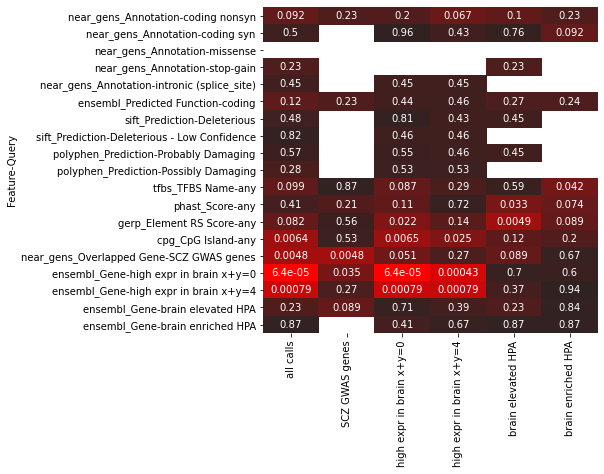

In [25]:
%matplotlib inline
cm = sns.dark_palette('red', as_cmap=True)
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(chisq_stat, annot=chisq_p, ax=ax, cmap=cm, cbar=False)
attila_utils.savefig(fig, 'chisq-heatmap')

### Sample mean and standard error 

In [26]:
operations.summarize_query_mean_sem(results, data)

Dx                                                      Control            \
                                                           mean       sem   
near_gens_Annotation       coding nonsyn                  0.575  0.022853   
                           coding syn                     0.400  0.016013   
                           missense                       0.000  0.000000   
                           stop-gain                      0.025  0.004003   
                           intronic (splice_site)         0.000  0.000000   
ensembl_Predicted Function coding                         0.975  0.032173   
sift_Prediction            Deleterious                    0.200  0.013074   
                           Deleterious - Low Confidence   0.025  0.004003   
polyphen_Prediction        Probably Damaging              0.075  0.006754   
                           Possibly Damaging              0.050  0.005588   
tfbs_TFBS Name             any                            1.200  0.029902   
phast_Score                any                            2.550  0.047953   
gerp_Element RS Score      any                            3.500  0.055883   
cpg_CpG Island             any                            0.650  0.021870   
near_gens_Overlapped Gene  SCZ GWAS genes                 0.500  0.019861   
ensembl_Gene               high expr in brain x+y=0      14.250  0.194242   
                           high expr in brain x+y=4       6.975  0.100865   
                           brain elevated HPA             5.275  0.090471   
                           brain enriched HPA             1.050  0.035320   

Dx                                                             SCZ            \
                                                              mean       sem   
near_gens_Annotation       coding nonsyn                  0.704918  0.017686   
                           coding syn                     0.327869  0.013737   
                           missense                       0.000000  0.000000   
                           stop-gain                      0.000000  0.000000   
                           intronic (splice_site)         0.016393  0.002116   
ensembl_Predicted Function coding                         1.049180  0.021642   
sift_Prediction            Deleterious                    0.147541  0.006637   
                           Deleterious - Low Confidence   0.016393  0.002116   
polyphen_Prediction        Probably Damaging              0.081967  0.005478   
                           Possibly Damaging              0.032787  0.002968   
tfbs_TFBS Name             any                            1.278689  0.025808   
phast_Score                any                            2.852459  0.040470   
gerp_Element RS Score      any                            4.295082  0.065031   
cpg_CpG Island             any                            0.770492  0.018454   
near_gens_Overlapped Gene  SCZ GWAS genes                 1.081967  0.024940   
ensembl_Gene               high expr in brain x+y=0      15.295082  0.217733   
                           high expr in brain x+y=4       7.180328  0.109790   
                           brain elevated HPA             5.639344  0.071034   
                           brain enriched HPA             1.131148  0.020126   

Dx                                                             ASD            
                                                              mean       sem  
near_gens_Annotation       coding nonsyn                  0.403509  0.013321  
                           coding syn                     0.263158  0.009177  
                           missense                       0.000000  0.000000  
                           stop-gain                      0.000000  0.000000  
                           intronic (splice_site)         0.000000  0.000000  
ensembl_Predicted Function coding                         0.701754  0.015316  
sift_Prediction            Deleterious                    0.105263  0

## TODO

Use Taejeong's definition of functional variants

> The terms that we chose as functional are missense, stop_gained, splice_region, regulatory, and TF_binding.

In [27]:
%connect_info

{
  "shell_port": 52101,
  "iopub_port": 50669,
  "stdin_port": 58427,
  "control_port": 56415,
  "hb_port": 49607,
  "ip": "127.0.0.1",
  "key": "ee3cdbaa-e1525c3db582526ae69ee99b",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-5b3e3413-8a49-4818-88f5-1e15209fe400.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
